# Programming Assignment 4

Celio Bueri, Christoph Stelz

## Exercise question

In the second example, the data are not linearly separable.

## Boilerplate code

In [24]:
import numpy as np
from sklearn.base import BaseEstimator

class LinearClassifier(BaseEstimator):
    """
    General class for binary linear classifiers. Implements the predict
    function, which is the same for all binary linear classifiers. There are
    also two utility functions.
    """

    def decision_function(self, X):
        """
        Computes the decision function for the inputs X. The inputs are assumed to be
        stored in a matrix, where each row contains the features for one
        instance.
        """
        return X.dot(self.w)

    def predict(self, X):
        """
        Predicts the outputs for the inputs X. The inputs are assumed to be
        stored in a matrix, where each row contains the features for one
        instance.
        """

        # First compute the output scores
        scores = self.decision_function(X)

        # Select the positive or negative class label, depending on whether
        # the score was positive or negative.
        out = np.select([scores >= 0.0, scores < 0.0],
                        [self.positive_class,
                         self.negative_class])
        return out

    def find_classes(self, Y):
        """
        Finds the set of output classes in the output part Y of the training set.
        If there are exactly two classes, one of them is associated to positive
        classifier scores, the other one to negative scores. If the number of
        classes is not 2, an error is raised.
        """
        classes = sorted(set(Y))
        if len(classes) != 2:
            raise Exception("this does not seem to be a 2-class problem")
        self.positive_class = classes[1]
        self.negative_class = classes[0]

    def encode_outputs(self, Y):
        """
        A helper function that converts all outputs to +1 or -1.
        """
        return np.array([1 if y == self.positive_class else -1 for y in Y])


## SVC Implementation

In [80]:
class SVCImpl(LinearClassifier):
    def __init__(self, n_iter=20, lr=0.01, regularizer=0.0, print_epoch_stats=True):
        """
        The constructor can optionally take a parameter n_iter specifying how
        many times we want to iterate through the training set.
        """
        self.n_iter = n_iter
        self.lr = lr
        self.regularizer = regularizer
        self.print_epoch_stats = print_epoch_stats

    def fit(self, X, Y):
        """
        Train a linear classifier using the perceptron learning algorithm.
        """

        # First determine which output class will be associated with positive
        # and negative scores, respectively.
        self.find_classes(Y)

        # Convert all outputs to +1 (for the positive class) or -1 (negative).
        Ye = self.encode_outputs(Y)

        # If necessary, convert the sparse matrix returned by a vectorizer
        # into a normal NumPy matrix.
        if not isinstance(X, np.ndarray):
            X = X.toarray()

        # Initialize the weight vector to all zeros.
        n_features = X.shape[1]
        self.w = np.zeros(n_features)

        indices = np.random.randint(X.shape[0], size=self.n_iter)

        t = 0
        for i in indices:
            t += 1

            lr = 1.0 / (self.regularizer * t)

            x, y = X[i], Ye[i]

            # Compute the output score for this instance.
            score = x.dot(self.w)

            if y * score < 1:
                self.w = (1 - self.regularizer * lr) * self.w + lr * y * x
            else:
                self.w = (1 - self.regularizer * self.lr) * self.w

            if self.print_epoch_stats and t % 100 == 0:
                print(f'iteration : {t}, train_loss : { - self.score(X, Y)}')

    def score(self, X, Y):
        loss = 0.0
        min_weight = np.min(self.w.dot(self.w))
        for x, y in zip(X, self.encode_outputs(Y)):
            # loss for svc
            loss += max(0.0, 1.0 - y * x.dot(self.w))
        return -(self.regularizer / 2 * min_weight + loss / X.shape[0])

## Logistic Regression Implementation

In [26]:
class LogisticRegressionImpl(LinearClassifier):
    def __init__(self, n_iter=20, lr=0.01, probability=False, regularizer=0.0, print_epoch_stats=True):
        """
        The constructor can optionally take a parameter n_iter specifying how
        many times we want to iterate through the training set.
        """
        self.n_iter = n_iter
        self.lr = lr
        self.probability = probability
        self.regularizer = regularizer
        self.print_epoch_stats = print_epoch_stats

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, Y):
        """
        Train a linear classifier using the perceptron learning algorithm.
        """

        # First determine which output class will be associated with positive
        # and negative scores, respectively.
        self.find_classes(Y)

        # First determine which output class will be associated with positive
        # and negative scores, respectively.
        Ye = self.encode_outputs(Y)

        # If necessary, convert the sparse matrix returned by a vectorizer
        # into a normal NumPy matrix.
        if not isinstance(X, np.ndarray):
            X = X.toarray()

        # Initialize the weight vector to all zeros.
        n_features = X.shape[1]
        self.w = np.zeros(n_features)

       # training algorithm:
        for i in range(self.n_iter):
            for x, y in zip(X, Ye):
                score = y * x.dot(self.w)
                self.w = (1 - self.regularizer * self.lr) * self.w + self.lr * y * self.sigmoid(-score) * x

            if self.print_epoch_stats:
                print(f'epoch : {i}, train_loss : {self.score(X, Y)}')

    def score(self, X, Y):
        loss = 0.0
        min_weight = np.min(self.w.dot(self.w))
        for x, y in zip(X, self.encode_outputs(Y)):
            # loss for logistic regression
            loss += float(np.log(1 + np.exp(-y * x.dot(self.w))))
        return self.regularizer / 2 * min_weight + loss / X.shape[0]

## Preparing training data

In [81]:

import time

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


def read_data(corpus_file):
    X = []
    Y = []
    with open(corpus_file, encoding='utf-8') as f:
        for line in f:
            _, y, _, x = line.split(maxsplit=3)
            X.append(x.strip())
            Y.append(y)
    return X, Y


# Read all the documents.
X, Y = read_data('data/all_sentiment_shuffled.txt')

# Split into training and test parts.
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2, random_state=0)


## Testing our classifiers 	

In [82]:

# Set up the preprocessing steps and the classifier.
pipeline = make_pipeline(
    TfidfVectorizer(),
    SelectKBest(k=1000),
    Normalizer(),
    SVCImpl(n_iter=10000, regularizer=0.001)
)

# Train the classifier.
t0 = time.time()
pipeline.fit(Xtrain, Ytrain)
t1 = time.time()
print('Training time: {:.2f} sec.'.format(t1-t0))

# Evaluate on the test set.
Yguess = pipeline.predict(Xtest)
print('Accuracy: {:.4f}.'.format(accuracy_score(Ytest, Yguess)))

iteration : 100, train_loss : 15.13428184811562
iteration : 200, train_loss : 8.744016828111363
iteration : 300, train_loss : 6.768464656447211
iteration : 400, train_loss : 5.531080971520089
iteration : 500, train_loss : 4.411445258614702
iteration : 600, train_loss : 3.923597682657262
iteration : 700, train_loss : 3.5054965811144476
iteration : 800, train_loss : 3.1219238352018284
iteration : 900, train_loss : 2.7884684354737233
iteration : 1000, train_loss : 2.550242790730322
iteration : 1100, train_loss : 2.358274367402297
iteration : 1200, train_loss : 2.21420985376166
iteration : 1300, train_loss : 2.0675918813457352
iteration : 1400, train_loss : 2.049127257652016
iteration : 1500, train_loss : 1.873211834217693
iteration : 1600, train_loss : 1.7753704323372206
iteration : 1700, train_loss : 1.7098193149832182
iteration : 1800, train_loss : 1.642994775704135
iteration : 1900, train_loss : 1.6672279265678074
iteration : 2000, train_loss : 1.5405542587359136
iteration : 2100, trai

In [6]:

# Set up the preprocessing steps and the classifier.
pipeline = make_pipeline(
    TfidfVectorizer(),
    SelectKBest(k=1000),
    Normalizer(),

    # NB that this is our LogisticRegression implementation
    LogisticRegressionImpl()
)

# Train the classifier.
t0 = time.time()
pipeline.fit(Xtrain, Ytrain)
t1 = time.time()
print('Training time: {:.2f} sec.'.format(t1-t0))

# Evaluate on the test set.
Yguess = pipeline.predict(Xtest)
print('Accuracy: {:.4f}.'.format(accuracy_score(Ytest, Yguess)))

epoch : 0, train_loss : 0.6288857169774531
epoch : 1, train_loss : 0.5840018940929901
epoch : 2, train_loss : 0.5511767701367489
epoch : 3, train_loss : 0.5261244113878396
epoch : 4, train_loss : 0.5062936920256184
epoch : 5, train_loss : 0.49011851663793615
epoch : 6, train_loss : 0.4765995710252395
epoch : 7, train_loss : 0.4650742894372502
epoch : 8, train_loss : 0.45508760073903537
epoch : 9, train_loss : 0.4463169192656121
epoch : 10, train_loss : 0.4385270914760717
epoch : 11, train_loss : 0.43154242018454747
epoch : 12, train_loss : 0.4252287470781953
epoch : 13, train_loss : 0.41948164728788945
epoch : 14, train_loss : 0.4142184477857359
epoch : 15, train_loss : 0.4093727030957251
epoch : 16, train_loss : 0.4048902894709579
epoch : 17, train_loss : 0.40072658932183824
epoch : 18, train_loss : 0.3968444253813822
epoch : 19, train_loss : 0.3932125202979789
Training time: 4.23 sec.
Accuracy: 0.8175.


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

param_grid = {
    'classifier__n_iter': [10, 30, 10],
    'classifier__regularizer': [0.1, 1, 2]
}


pipeline = Pipeline(steps=[
    ("vect",TfidfVectorizer()),
    ("select", SelectKBest(k=1000)),
    ("norm", Normalizer()),
    ("classifier", SVCImpl(print_epoch_stats=False))
])

grid_search = GridSearchCV(pipeline, param_grid, n_jobs=-1, return_train_score=True)

grid_search.fit(X, Y)

print("Best parameter (loss=%0.3f):" % grid_search.best_score_)
print(grid_search.best_params_)

## Optimizing Performance

### a) BLAS operations

In this version we replaced the Numpy operations with BLAS functions from scipy.
One pitfall we encountered is that with inplace operations like `daxpy`, the argument ordering matters a lot.

In [60]:
from scipy.linalg.blas import ddot, dscal, daxpy

class SVCImplBLAS(LinearClassifier):
    def __init__(self, n_iter=20, lr=0.01, regularizer=0.0, print_epoch_stats=True):
        """
        The constructor can optionally take a parameter n_iter specifying how
        many times we want to iterate through the training set.
        """
        self.n_iter = n_iter
        self.lr = lr
        self.regularizer = regularizer
        self.print_epoch_stats = print_epoch_stats

    def fit(self, X, Y):
        """
        Train a linear classifier using the perceptron learning algorithm.
        """

        # First determine which output class will be associated with positive
        # and negative scores, respectively.
        self.find_classes(Y)

        # Convert all outputs to +1 (for the positive class) or -1 (negative).
        Ye = self.encode_outputs(Y)

        # If necessary, convert the sparse matrix returned by a vectorizer
        # into a normal NumPy matrix.
        if not isinstance(X, np.ndarray):
            X = X.toarray()

        # Initialize the weight vector to all zeros.
        n_features = X.shape[1]
        self.w = np.zeros(n_features)

        # training algorithm:
        for i in range(self.n_iter):
            for x, y in zip(X, Ye):

                # Compute the output score for this instance.
                score = ddot(self.w, x)
                
                dscal(1 - self.regularizer * self.lr, self.w)
                if y * score < 1:
                    daxpy(x, self.w, a=(self.lr * y))
                
            if self.print_epoch_stats:
                print(f'epoch : {i}, train_loss : {self.score(X, Y)}')

    def score(self, X, Y):
        loss = 0.0
        min_weight = np.min(ddot(self.w, self.w))
        for x, y in zip(X, self.encode_outputs(Y)):
            # loss for svc
            loss += max(0.0, 1.0 - y * x.dot(self.w))
        return self.regularizer / 2 * min_weight + loss / X.shape[0]

### b) Sparse Vectors

In [91]:
def add_sparse_to_dense(x, w, factor):
    """
    Adds a sparse vector x, scaled by some factor, to a dense vector.
    This can be seen as the equivalent of w += factor * x when x is a dense
    vector.
    """
    w[x.indices] += factor * x.data

def sparse_dense_dot(x, w):
    """
    Computes the dot product between a sparse vector x and a dense vector w.
    """
    return np.dot(w[x.indices], x.data)


class SparseSVC(LinearClassifier):

    def __init__(self, n_iter=1000, regularizer=0.001, print_epoch_stats=True):
        self.n_iter = n_iter
        self.regularizer = regularizer
        self.print_epoch_stats = print_epoch_stats

    def fit(self, X, Y):
        self.find_classes(Y)

        # First determine which output class will be associated with positive
        # and negative scores, respectively.
        Ye = self.encode_outputs(Y)

        # Initialize the weight vector to all zeros.
        self.w = np.zeros(X.shape[1])

        # Iteration through sparse matrices can be a bit slow, so we first
        # prepare this list to speed up iteration.

        indices = np.random.randint(1,X.shape[0], size=self.n_iter)

        XY = list(zip(X[indices], Ye[indices]))

        t = 0
        for i in range(self.n_iter):
            t += 1

            lr = 1.0 / (self.regularizer * t)

            x, y = XY[i]

            # Compute the output score for this instance.
            score = sparse_dense_dot(x, self.w)

            (1 - self.regularizer * lr) * self.w + lr * y * x

            # regularizer
            self.w *= (1 - self.regularizer * lr)
            # If there was an error, update the weights.
            if y*score <= 0:
                add_sparse_to_dense(x, self.w, lr * y)

            if self.print_epoch_stats and t % 1000 == 0:
                print(f'iteration : {t}, train_loss : { - self.score(X, Y)}')


    def score(self, X, Y):
        loss = 0.0
        min_weight = np.min(self.w.dot(self.w))
        for x, y in zip(X, self.encode_outputs(Y)):
            # loss for svc
            loss += max(0.0, 1.0 - y * x.dot(self.w))
        return -(self.regularizer / 2.0 * min_weight + loss / X.shape[0])

In [92]:
# Set up the preprocessing steps and the classifier.
pipeline = make_pipeline(
    TfidfVectorizer(ngram_range=(1,2)),
    Normalizer(),

    # NB that this is our LogisticRegression implementation
    SparseSVC(n_iter=10000, regularizer=0.0001)
)

# Train the classifier.
t0 = time.time()
pipeline.fit(Xtrain, Ytrain)
t1 = time.time()
print('Training time: {:.2f} sec.'.format(t1-t0))

# Evaluate on the test set.
Yguess = pipeline.predict(Xtest)
print('Accuracy: {:.4f}.'.format(accuracy_score(Ytest, Yguess)))

iteration : 1000, train_loss : [2.03824451]
iteration : 2000, train_loss : [1.19830306]
iteration : 3000, train_loss : [0.97008858]
iteration : 4000, train_loss : [0.87433692]
iteration : 5000, train_loss : [0.81274848]
iteration : 6000, train_loss : [0.7683792]
iteration : 7000, train_loss : [0.75054165]
iteration : 8000, train_loss : [0.74559668]
iteration : 9000, train_loss : [0.74120014]
iteration : 10000, train_loss : [0.74267376]
Training time: 40.75 sec.
Accuracy: 0.8116.


### c) Faster scaling

In [96]:
def add_sparse_to_dense(x, w, factor):
    """
    Adds a sparse vector x, scaled by some factor, to a dense vector.
    This can be seen as the equivalent of w += factor * x when x is a dense
    vector.
    """
    w[x.indices] += factor * x.data

def sparse_dense_dot(x, w, a):
    """
    Computes the dot product between a sparse vector x and a dense vector w.
    """
    return a * np.dot(w[x.indices], x.data)


class SparseSVC(LinearClassifier):

    def __init__(self, n_iter=1000, regularizer=0.001, print_epoch_stats=True):
        self.n_iter = n_iter
        self.regularizer = regularizer
        self.print_epoch_stats = print_epoch_stats

    def fit(self, X, Y):
        self.find_classes(Y)

        # First determine which output class will be associated with positive
        # and negative scores, respectively.
        Ye = self.encode_outputs(Y)

        # Initialize the weight vector to all zeros.
        self.w = np.zeros(X.shape[1])

        # Iteration through sparse matrices can be a bit slow, so we first
        # prepare this list to speed up iteration.

        indices = np.random.randint(1,X.shape[0], size=self.n_iter)

        XY = list(zip(X[indices], Ye[indices]))

        # initialize vector scaling
        a = 1

        t = 0
        for i in range(self.n_iter):
            t += 1

            lr = 1.0 / (self.regularizer * t)

            x, y = XY[i]

            # Compute the output score for this instance.
            score = sparse_dense_dot(x, self.w, a)

            # If there was an error, update the weights.
            if y*score <= 0:
                add_sparse_to_dense(x, self.w, (lr * y / a))

            # update vector scaling
            if (1 - self.regularizer * lr) * a > 0:
                a = (1 - self.regularizer * lr) * a

        self.w[x.indices] =  a * self.w[x.indices]

    def score(self, X, Y):
        loss = 0.0
        min_weight = np.min(self.w.dot(self.w))
        for x, y in zip(X, self.encode_outputs(Y)):
            # loss for svc
            loss += max(0.0, 1.0 - y * x.dot(self.w))
        return -(self.regularizer / 2 * min_weight + loss / X.shape[0])

In [98]:
# Set up the preprocessing steps and the classifier.
pipeline = make_pipeline(
    TfidfVectorizer(ngram_range=(1,2)),
    Normalizer(),

    # NB that this is our LogisticRegression implementation
    SparseSVC(n_iter=100000, regularizer=0.0001)
)

# Train the classifier.
t0 = time.time()
pipeline.fit(Xtrain, Ytrain)
t1 = time.time()
print('Training time: {:.2f} sec.'.format(t1-t0))

# Evaluate on the test set.
Yguess = pipeline.predict(Xtest)
print('Accuracy: {:.4f}.'.format(accuracy_score(Ytest, Yguess)))

Training time: 6.16 sec.
Accuracy: 0.8548.


### Performance Evaluation

In [72]:
def evaluate_pipeline(pipeline):
    pipeline.fit(Xtrain, Ytrain) # make sure its fitted
    Yguess = pipeline.predict(Xtest)
    print('Accuracy: {:.4f}.'.format(accuracy_score(Ytest, Yguess)))

#### Baseline

In [70]:
%%timeit
pipeline_baseline = make_pipeline(
    TfidfVectorizer(),
    SelectKBest(k=1000),
    Normalizer(),
    SVCImpl(print_epoch_stats=False)
)
pipeline_baseline.fit(Xtrain, Ytrain)

2.52 s ± 134 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [73]:
evaluate_pipeline(pipeline_baseline)

Accuracy: 0.8363.


#### BLAS

In [74]:
%%timeit

pipeline_blas = make_pipeline(
    TfidfVectorizer(),
    SelectKBest(k=1000),
    Normalizer(),
    SVCImplBLAS(print_epoch_stats=False)
)
pipeline_blas.fit(Xtrain, Ytrain)

2.13 s ± 94.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [75]:
evaluate_pipeline(pipeline_blas)

Accuracy: 0.8363.


### Visualization

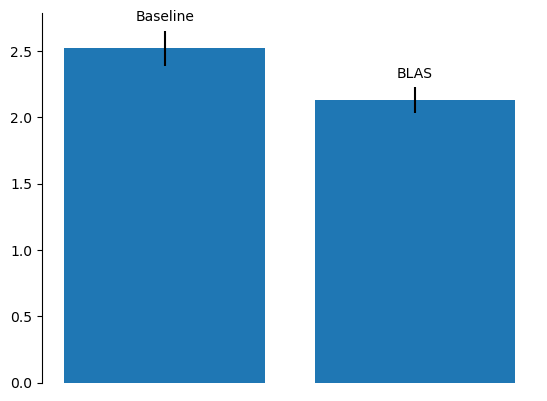

In [87]:
import matplotlib.pyplot as plt

f, ax = plt.subplots()
b = ax.bar([1,2], [2.52, 2.13], yerr=[134e-3, 94.5e-3], width=0.8)
ax.bar_label(b, labels=['Baseline', 'BLAS'], padding=5)
ax.spines[['right', 'top', 'bottom']].set_visible(False)
ax.get_xaxis().set_visible(False)